In [11]:
import os
import ast
import textwrap
import tiktoken
import keyboard
import matplotlib.pyplot as plt
import numpy as np
import umap.umap_ as umap
import pandas as pd
from langchain.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_openai import ChatOpenAI
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import PyPDFLoader
from langchain.document_loaders import DirectoryLoader
from langchain import PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.runnables import RunnableParallel
from langchain_core.output_parsers import StrOutputParser
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from dotenv import load_dotenv, find_dotenv
from typing import Optional

In [2]:
load_dotenv(find_dotenv())
embeddings = OpenAIEmbeddings()

detailed_turbo_llm = turbo_llm = ChatOpenAI(
    temperature=0,
    model_name='gpt-3.5-turbo-0125'
)

turbo_llm = ChatOpenAI(
    temperature=0.7,
    model_name='gpt-3.5-turbo-0125'
)

# Eliminar la primera página o portada del doc.

In [3]:
# Carga de documentos y extracción de información
# (asegúrate de que haya PDFs en la carpeta documentos)
documents = DirectoryLoader('./docs/', glob="./*.pdf", loader_cls=PyPDFLoader).load()
# Tratameinto de caracteres indeseados
for d in documents:
    d.page_content = d.page_content.replace('\n', ' ').replace('\t', ' ')
# Separador de texto (límita el texto para que sea soportado por el LLM)
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=3000,
    chunk_overlap=500
)
docs = text_splitter.split_documents(documents)
texts = [doc.page_content for doc in docs]

In [4]:
def num_tokens_from_string(string: str) -> int:
    encoding = tiktoken.get_encoding("cl100k_base")
    num_tokens = len(encoding.encode(string))
    return num_tokens

counts = [num_tokens_from_string(t) for t in texts]

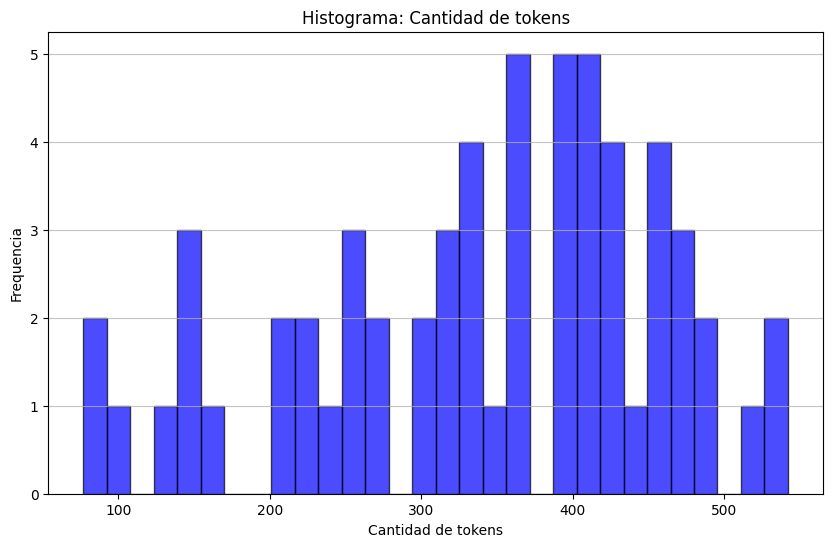

In [5]:
plt.figure(figsize=(10, 6))
plt.hist(counts, bins=30, color="blue", edgecolor="black", alpha=0.7)
plt.title("Histograma: Cantidad de tokens")
plt.xlabel("Cantidad de tokens")
plt.ylabel("Frequencia")
plt.grid(axis="y", alpha=0.75)
plt.show()

In [6]:
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)
print(
    "Num tokens in all context: %s"
    % num_tokens_from_string(concatenated_content)
)

Num tokens in all context: 20539


# 1. ¿Incrustar de cero?
# 2. ¿Elegir un encrustamiento guardado?

In [18]:
while True:
    user_input = input("Elige '1', '2' o 'Esc' para salir: ")

    if user_input.lower() == "1":
        print('Elegiste 1')
        global_embeddings = [embeddings.embed_query(txt) for txt in texts]

        embed_name = input('¿Cómo se llama esta incrustación?: ') + '_emb' + '.txt'
        with open(rf'./embed/{embed_name}', 'w') as f:
            for i in global_embeddings:
                f.write("%s\n" % i)
        break
    elif user_input.lower() == "2":
        print('Elegiste 2')
        global_embeddings = []

        embed_name = input('Nombre del encrustamiento: ') + '_emb' + '.txt'

        with open(rf'./embed/{embed_name}', 'r') as f:
            for i in f:
                x = ast.literal_eval(i.strip())  # Convertir la cadena a lista de números
                global_embeddings.append(x)

        global_embeddings = np.array(global_embeddings, dtype=float)
        break
    elif user_input.lower() == "esc":
        print("No seleccionaste ningún encrustamiento.")
        break
    else:
        print("Entrada no válida. Por favor, elige '1', '2' o 'Esc' para salir.")

Elegiste 1


In [19]:
def reduce_cluster_embeddings(
    embeddings: np.ndarray,
    dim: int,
    n_neighbors: Optional[int] = None,
    metric: str = "cosine",
) -> np.ndarray:
    if n_neighbors is None:
        n_neighbors = int((len(embeddings) - 1) ** 0.5)
    return umap.UMAP(
        n_neighbors=n_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)

dim = 2
global_embeddings_reduced = reduce_cluster_embeddings(global_embeddings, dim)

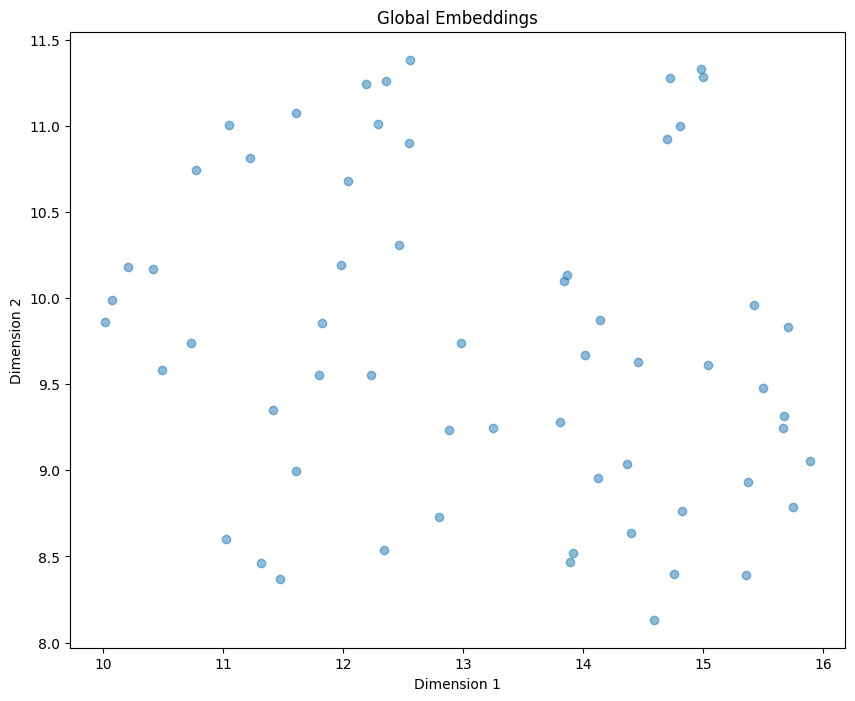

In [20]:
plt.figure(figsize=(10, 8))
plt.scatter(global_embeddings_reduced[:, 0], global_embeddings_reduced[:, 1], alpha=0.5)
plt.title("Global Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

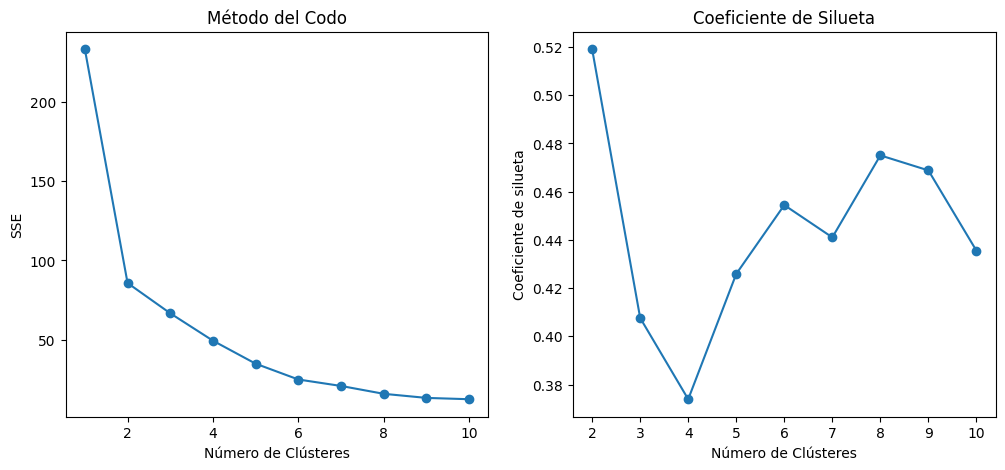

Número óptimo de clústeres según el método del codo: 1
Número óptimo de clústeres según el coeficiente de silueta: 2


In [23]:
# Método del Codo
sse = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(global_embeddings_reduced)
    sse.append(kmeans.inertia_)

# Coeficiente de Silueta
silhouette_scores = []
for k in k_values[1:]:  # Silhouette score no está definido para k=1
    kmeans = KMeans(n_clusters=k, random_state=0).fit(global_embeddings_reduced)
    score = silhouette_score(global_embeddings_reduced, kmeans.labels_)
    silhouette_scores.append(score)

# Graficar el método del codo
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_values, sse, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de Clústeres')
plt.ylabel('SSE')

# Graficar el coeficiente de silueta
plt.subplot(1, 2, 2)
plt.plot(k_values[1:], silhouette_scores, marker='o')
plt.title('Coeficiente de Silueta')
plt.xlabel('Número de Clústeres')
plt.ylabel('Coeficiente de silueta')
plt.show()

# Determinación del número óptimo de clústeres
optimal_k_elbow = np.argmin(np.diff(sse)) + 1  # Codo
optimal_k_silhouette = k_values[1:][np.argmax(silhouette_scores)]  # Silueta

print(f"Número óptimo de clústeres según el método del codo: {optimal_k_elbow}")
print(f"Número óptimo de clústeres según el coeficiente de silueta: {optimal_k_silhouette}")

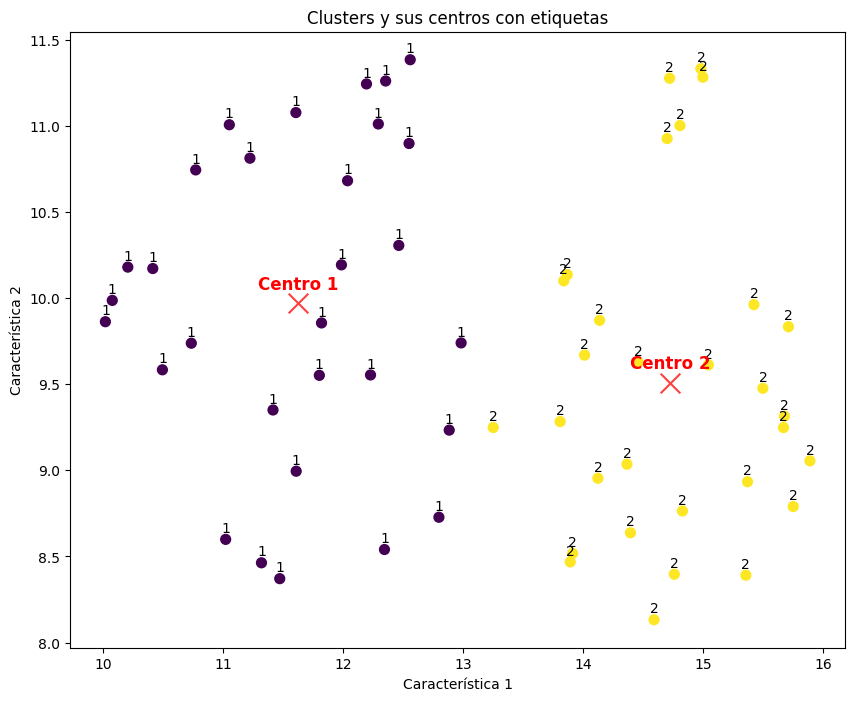

In [24]:
# Suponiendo que 'global_embeddings_reduced' ya está definido
optimal_k = input('¿Cuántos clústeres quiere usar?: ')

kmeans = KMeans(n_clusters=int(optimal_k), random_state=0).fit(global_embeddings_reduced)
labels = kmeans.labels_ + 1  # Agregar 1 a las etiquetas de los clústeres
centers = kmeans.cluster_centers_

# Visualizar los datos y los centros de los clústeres
plt.figure(figsize=(10, 8))
plt.scatter(global_embeddings_reduced[:, 0], global_embeddings_reduced[:, 1], c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='x')

# Añadir etiquetas a los puntos de datos
for i in range(len(global_embeddings_reduced)):
    plt.annotate(str(labels[i]), (global_embeddings_reduced[i, 0], global_embeddings_reduced[i, 1]),
                 textcoords="offset points", xytext=(0,5), ha='center')

# Añadir etiquetas a los centros de los clústeres
for i, center in enumerate(centers):
    plt.annotate(f'Centro {i+1}', (center[0], center[1]), textcoords="offset points", xytext=(0,10), ha='center', color='red', fontsize=12, weight='bold')

plt.title("Clusters y sus centros con etiquetas")
plt.xlabel("Característica 1")
plt.ylabel("Característica 2")
plt.show()

# Aplicar análisis a base de datos para determinar de qué habla (tema principal) cada clúster.

In [25]:
df = pd.DataFrame({
    'Texto': texts,
    'Embedding': list(global_embeddings_reduced),
    'Cluster': labels
})
df.head()
doc_nom = input('Ingrese el nombre del documento')
df.to_csv(f'{doc_nom}.csv', sep=';', encoding='utf-8-sig')

In [26]:
def format_cluster_texts(df):
    clustered_texts = {}
    for cluster in df['Cluster'].unique():
        cluster_texts = df[df['Cluster'] == cluster]['Texto'].tolist()
        clustered_texts[cluster] = " --- ".join(cluster_texts)
    return clustered_texts

clustered_texts = format_cluster_texts(df)
clustered_texts

{1: 'Impacto de la innovación de producto, innovación de  proceso, innovación organizacional y la percepción de la  corrupción, en la rentabilidad empresarial en Colombia   1       Impacto de la innovación de producto, innovación de proceso, innovación  organizacional y la percepción de la corrupción, en la rentabilidad empresarial en  Colombia       Gueiriluz Romero Chaparro   Juan Felipe Gó mez Quiceno       Universidad EAN   Facultad de Administración   Maestría en administración de empresas   Bogotá  D.C, Colombia    Julio  de 2022 --- Impacto de la innovación de producto, innovación de  proceso, innovación organizacional y la percepción de la  corrupción, en la rentabilidad empresarial en Colombia   2     Implicaciones de la innovación empresarial  en Colombia   Juan Felipe Gómez Quiceno   Gueiriluz Romero Chaparro     Trabajo de grado presentado como  requisito para optar al título de:   Magister en administración de empresas   Director :  Juan Manuel Gil Barragán     Modalidad: 

# Hay que volver a hacer un split de texto para solucionar problemas de capacidad en el LLM.

In [27]:
template = """Eres un asistente capaz de crear resúmenes extremadamente detallados del texto proporcionado.

Texto:
{text}
"""

prompt = PromptTemplate.from_template(template)
chain = prompt | detailed_turbo_llm | StrOutputParser()

In [28]:
summaries = {}
for cluster, text in clustered_texts.items():
    summary = chain.invoke({"text": text})
    summaries[cluster] = summary

summaries

{1: 'El impacto de la innovación de producto, innovación de proceso, innovación organizacional y la percepción de la corrupción en la rentabilidad empresarial en Colombia es un tema de estudio abordado por Gueiriluz Romero Chaparro y Juan Felipe Gómez Quiceno en su trabajo de grado para la Maestría en Administración de Empresas de la Universidad EAN en Bogotá, Colombia.\n\nEl estudio se enfoca en analizar cómo la innovación en diferentes aspectos de una empresa, como productos, procesos y organización, así como la percepción de corrupción, influyen en su rentabilidad. Se utilizó un enfoque cuantitativo y se recolectaron datos a través de un cuestionario del Banco Mundial aplicado en empresas de manufactura en Colombia en 2017.\n\nLos resultados mostraron que la innovación de procesos y organizacional impacta positivamente en la rentabilidad de la empresa, mientras que la innovación de productos también tiene un efecto positivo a mediano y largo plazo. Sin embargo, la percepción de corr

In [29]:
clustered_summaries = {}
for label, summary in zip(labels, summaries.values()):
    if label not in clustered_summaries:
        clustered_summaries[label] = []
    clustered_summaries[label].append(summary)

clustered_summaries

{1: ['El impacto de la innovación de producto, innovación de proceso, innovación organizacional y la percepción de la corrupción en la rentabilidad empresarial en Colombia es un tema de estudio abordado por Gueiriluz Romero Chaparro y Juan Felipe Gómez Quiceno en su trabajo de grado para la Maestría en Administración de Empresas de la Universidad EAN en Bogotá, Colombia.\n\nEl estudio se enfoca en analizar cómo la innovación en diferentes aspectos de una empresa, como productos, procesos y organización, así como la percepción de corrupción, influyen en su rentabilidad. Se utilizó un enfoque cuantitativo y se recolectaron datos a través de un cuestionario del Banco Mundial aplicado en empresas de manufactura en Colombia en 2017.\n\nLos resultados mostraron que la innovación de procesos y organizacional impacta positivamente en la rentabilidad de la empresa, mientras que la innovación de productos también tiene un efecto positivo a mediano y largo plazo. Sin embargo, la percepción de cor

In [30]:
final_summaries = {}
for cluster, texts in clustered_summaries.items():
    combined_text = ' '.join(texts)
    summary = chain.invoke({"text": combined_text})
    final_summaries[cluster] = summary

final_summaries

{1: 'El impacto de la innovación de producto, innovación de proceso, innovación organizacional y la percepción de la corrupción en la rentabilidad empresarial en Colombia es analizado en un estudio realizado por Gueiriluz Romero Chaparro y Juan Felipe Gómez Quiceno para su trabajo de grado en la Maestría en Administración de Empresas de la Universidad EAN en Bogotá, Colombia. El estudio se enfoca en cómo estos aspectos influyen en la rentabilidad de las empresas, utilizando un enfoque cuantitativo y datos recolectados a través de un cuestionario del Banco Mundial aplicado en empresas de manufactura en Colombia en 2017.\n\nLos resultados mostraron que la innovación de procesos y organizacional impacta positivamente en la rentabilidad, mientras que la innovación de productos también tiene un efecto positivo a mediano y largo plazo. Sin embargo, la percepción de corrupción no mostró una correlación significativa con la rentabilidad. Se concluyó que la innovación empresarial, cuando se imp

In [31]:
texts_from_df = df['Texto'].tolist()
texts_from_clustered_texts = list(clustered_texts.values())
texts_from_final_summaries = list(final_summaries.values())

combined_texts = texts_from_df + texts_from_clustered_texts + texts_from_final_summaries

In [32]:
combined_texts[:10]

['Impacto de la innovación de producto, innovación de  proceso, innovación organizacional y la percepción de la  corrupción, en la rentabilidad empresarial en Colombia   1       Impacto de la innovación de producto, innovación de proceso, innovación  organizacional y la percepción de la corrupción, en la rentabilidad empresarial en  Colombia       Gueiriluz Romero Chaparro   Juan Felipe Gó mez Quiceno       Universidad EAN   Facultad de Administración   Maestría en administración de empresas   Bogotá  D.C, Colombia    Julio  de 2022',
 'Impacto de la innovación de producto, innovación de  proceso, innovación organizacional y la percepción de la  corrupción, en la rentabilidad empresarial en Colombia   2     Implicaciones de la innovación empresarial  en Colombia   Juan Felipe Gómez Quiceno   Gueiriluz Romero Chaparro     Trabajo de grado presentado como  requisito para optar al título de:   Magister en administración de empresas   Director :  Juan Manuel Gil Barragán     Modalidad:   M

In [39]:
# Nombre del archivo de texto
file_name = "test.txt"

# Escribir la lista en el archivo de texto
with open(file_name, 'w', encoding='utf-8') as f:
    for t in combined_texts:
        f.write("%s\n" % t)

# Leer el contenido del archivo y mostrarlo
with open(file_name, 'r', encoding='utf-8') as f:
    content = f.read()

#print(f"El archivo '{file_name}' ha sido creado con éxito.")

In [41]:
print(content)

Impacto de la innovación de producto, innovación de  proceso, innovación organizacional y la percepción de la  corrupción, en la rentabilidad empresarial en Colombia   1       Impacto de la innovación de producto, innovación de proceso, innovación  organizacional y la percepción de la corrupción, en la rentabilidad empresarial en  Colombia       Gueiriluz Romero Chaparro   Juan Felipe Gó mez Quiceno       Universidad EAN   Facultad de Administración   Maestría en administración de empresas   Bogotá  D.C, Colombia    Julio  de 2022
Impacto de la innovación de producto, innovación de  proceso, innovación organizacional y la percepción de la  corrupción, en la rentabilidad empresarial en Colombia   2     Implicaciones de la innovación empresarial  en Colombia   Juan Felipe Gómez Quiceno   Gueiriluz Romero Chaparro     Trabajo de grado presentado como  requisito para optar al título de:   Magister en administración de empresas   Director :  Juan Manuel Gil Barragán     Modalidad:   Monogra

In [43]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=3000,
    chunk_overlap=500
)

textos = text_splitter.split_text(content)

# Guardar los kb en una carpeta (kbs)

### 1. Enseñar

In [44]:
persist_directory = input('¿Cómo se llama este knoledge-base?: ') + '_kb'
vectorstore = Chroma.from_texts(texts=textos,
                                embedding=embeddings,
                                persist_directory=persist_directory)
vectorstore.persist()
vectorstore = None
os.system(f'zip -r db.zip ./{persist_directory}')

c:\Users\luisr\OneDrive\Documentos\GitHub\1day_1thing\.venv\Lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  warn_deprecated(


1

### 2. Recordar (si y solo si Enseñar=Done) y pregunta de control

In [45]:
persist_directory = input('¿Qué knoledge-base deseas usar?: ') + '_kb'
embedding = OpenAIEmbeddings()
vectorstore = Chroma(persist_directory=persist_directory, 
                  embedding_function=embedding)

def adjust_final_number(string: str, max_threshold: int, initial_number: int) -> int:
    final_number = initial_number
    while final_number < max_threshold:
        retriever = vectorstore.as_retriever(search_kwargs={"k": final_number})
        docs = retriever.invoke(string)
        text = "".join([doc.page_content for doc in docs])
        if num_tokens_from_string(text) < max_threshold:
            final_number += 1
        else:
            break
    return final_number

final_number = adjust_final_number("¿Cuál es el tema pricipal del documento?", 10000, 4)
print(final_number)
retriever = vectorstore.as_retriever(search_kwargs={"k": final_number})

17


In [46]:
# Se personaliza el LLM
template = """
Eres Prometeo, un asistente personal de revisión biliográfica que habla Español.

Tu tarea consiste en:

1. Leer detalladamente la información proporcionada en documentos que generalmente son
artículos científicos en formato PDF.

2. Proporcionar respuestas extremadamente detalladas a cualquier tipo de pregunta relacionada 
con el contexto, especialmente a preguntas específicas. Evita concluir tus respuestas con un 
párrafo que comience con 'En resumen,...'. Varía las conclusiones de tus respuestas para que 
sean más diversas y creativas.

3. Ser carismático y ofrecer información sobre ti y tus funciones.

SIEMPRE debes responder con base al contexto proporcionado aqui: {context}.
        
Si no sabes la respuesta, puedes decir: 'No sé'.

NUNCA hables específicamente del contexto.

NUNCA terminar las respuestas con un resumen o una conclusión predecible.

Teniendo en cuenta TODO lo anterior, responde la siguiente pregunta: {question}
"""

prometeo_prompt = PromptTemplate(
    template=template, input_variables=["context", "question"]
)

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = (
    RunnablePassthrough.assign(context=(lambda x: format_docs(x["context"])))
    | prometeo_prompt
    | turbo_llm
    | StrOutputParser()
)

rag_chain_with_source = RunnableParallel(
    {"context": retriever, "question": RunnablePassthrough()}
).assign(answer=rag_chain
)

In [51]:
def wrap_text_preserve_newlines(text, width=70):
    lines = text.split('\n')
    wrapped_lines = [textwrap.fill(line, width=width) for line in lines]
    wrapped_text = '\n'.join(wrapped_lines)
    return wrapped_text

def process_llm_response(llm_response):
    print(wrap_text_preserve_newlines(llm_response['answer']))
    print('\nReferencias:')
    for contexto in llm_response["context"][:5]:
        print(contexto)

In [52]:
# Demo
query = input("Hazme una pregunta: ")
print(query)
llm_response = rag_chain_with_source.invoke(query)
process_llm_response(llm_response)

¿Cuál es la metodología usada en el estudio?
La metodología utilizada en el estudio se basa en un enfoque de
investigación cuantitativa. Se recopilaron datos a través de un
cuestionario aplicado a empresas del sector manufacturero en Colombia
en el año 2017. Se emplearon técnicas analíticas para descubrir
posibles relaciones entre los factores de estudio y los efectos en la
rentabilidad empresarial. Además, se realizaron análisis estadísticos
como correlaciones de Pearson, ANOVA y Prueba T para validar las
hipótesis planteadas en la investigación. Este enfoque permitió
obtener conclusiones que respondieran a los objetivos específicos del
estudio.

Referencias:
page_content='establecimiento gastó en actividades  formales de investigación y desarrollo, ya sea de manera interna o contratada con  otras empresas, excluidas las encuestas de investigación de mercado?   6) M1: Mirando las opciones de la tabla, ¿puede decir cuáles  de los elementos del  entorno del negocio incluidos en la lista

# Hacer historial